# Assignment 8 & 9

This assignement will be covered with two tutorium, you don't have to give back any work before holidays. The next part will be uploaded during the holidays and after the next tutorium after holidays, you will have to give back your work. 

## Ex. 8.0
We start by installing pytorch, a popular machine learning framework. Go to [pytorch.org](https://pytorch.org/), choose your target system and install pytorch (via conda).

You can try pytorch on [Google Colab](https://colab.research.google.com), too. Colab integrates with your Google account, your notebooks will be stored on Google Drive and you can read datasets from there too. You can even use GPUs and TPUs! However, we still suggest you install pytorch on your local computer because variables might get lost when your computer disconnects from the internet or the notebook runs idle for a while.  

Browse through the [pytorch tutorials ](https://pytorch.org/tutorials/), they often come as colab notebooks - go and execute some!

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## Ex. 8.1
Make your own convolutionnal network of the following structure : 3 layer of convolution and 2 layer of neurones. We would like to see in it some padding, stride, pooling, drop out and batch normalization. Use the ReLU activation fonction. You should define your network, make a train fonction, a test fonction to display the result and make them work!

Setup some hyper-parameter for your network

In [2]:
n_epochs = 3
batch_size_train = 10
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Now, load MNIST from torch and 

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])),
  batch_size=batch_size_test, shuffle=True)

0it [00:00, ?it/s]

URLError: <urlopen error [Errno -2] Name or service not known>

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

Display some instance of the training set

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
#Good luck!

# Assignment 9

Now we will try to put in place some transfer learning program. We will work on the VGG 16 network (https://arxiv.org/pdf/1409.1556.pdf) designed in 2014. 
Then, because we know you all have a degree in medicine, we will try our luck bu doing some! We will then retrain the last layer of the network to be able to recognize pneumonia on X-Ray images. First download the database available here (ChestXRay2017, 1.2Gb) : https://data.mendeley.com/datasets/rscbjbr9sj/2

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu: print("Using CUDA") 
else: print("No CUDA found")

No CUDA found


In [2]:
data_dir = '../chest_xray'
TRAIN = 'train'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

for x in [TRAIN, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 5232 images under train
Loaded 624 images under test
Classes: 
['NORMAL', 'PNEUMONIA']


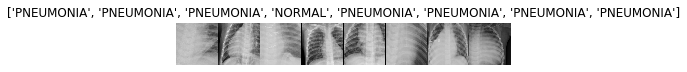

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [4]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16.classifier[6].out_features) # 1000 

1000


In [5]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data[0]
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [9]:
log_interval = 10
n_epochs = 2
momentum = 0.9
learning_rate = 0.01

optimizer = optim.SGD(vgg16.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(dataloaders[TRAIN].dataset) for i in range(n_epochs + 1)]


def train(epoch):
  vgg16.train()
  for batch_idx, (data, target) in enumerate(dataloaders[TRAIN]):
    optimizer.zero_grad()                         #put the gradient at 0
    output = vgg16(data)                        #feed forward
    loss = criterion(output, target)
    loss.backward()                               #feed the loss backward
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(dataloaders[TRAIN].dataset),
        100. * batch_idx / len(dataloaders[TRAIN]), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(dataloaders[TRAIN].dataset)))
      torch.save(vgg16.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [10]:
vgg16 = train(n_epochs)
torch.save(vgg16.state_dict(), 'VGG16_v2-OCT_Pneumonia_half_dataset.pt')

Train Epoch: 2 [0/5232 (0%)]	Loss: 0.692798
Train Epoch: 2 [80/5232 (2%)]	Loss: 0.840473
Train Epoch: 2 [160/5232 (3%)]	Loss: nan
Train Epoch: 2 [240/5232 (5%)]	Loss: nan


KeyboardInterrupt: 